In [1]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras import backend as K

Using TensorFlow backend.


####Making Data Ready

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

#####DATA

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/HumanActivityRecognition.zip (Unzipped Files)/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HumanActivityRecognition.zip (Unzipped Files)/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. 
    """
    filename = f'/content/drive/My Drive/HumanActivityRecognition.zip (Unzipped Files)/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

In [0]:
# Import Keras
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [14]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [0]:
def accuracy_loss(history):
  """
   This function plots accuracy and loss  plots for a given model
   took referance from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
  """
  plt.figure()
  plt.subplot(121)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy Plot')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss Plot')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  

italicized text

####Defining Architechture

####2 Layer Mode (Dropout = 0.6)

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = 128
dropout_rate = 0.6

In [17]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(LSTM(16,input_shape=(timesteps, 32)))
model.add(Dropout(dropout_rate))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.4584 - acc: 0.4329 - val_loss: 1.3157 - val_acc: 0.4533
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2142 - acc: 0.5203 - val_loss: 1.1551 - val_acc: 0.5887
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.0721 - acc: 0.5464 - val_loss: 0.9551 - val_acc: 0.6430
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9837 - acc: 0.5581 - val_loss: 0.8726 - val_acc: 0.5884
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.9167 - acc: 0.6069 - val_loss: 0.8160 - val_acc: 0.6854
Epoch 6/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.8560 - acc: 0.6394 - val_loss: 0.8060 - val_acc: 0.6810
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7927 - acc: 0.6

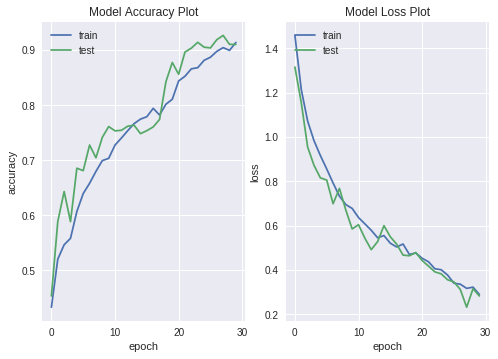

2947/2947 [==============================] - 2s 641us/step


In [19]:
# to plot accuracy/loss plots
accuracy_loss(history)

# score calculation
score = model.evaluate(X_test, Y_test)
model_loss_6 = score[0]
model_accuracy_6 = score[1]

In [20]:
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.28306087015040565, 0.9104173736002714]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  2      418        65        0                   0   
STANDING                 0      122       409        1                   0   
WALKING                  0        0         0      458                  23   
WALKING_DOWNSTAIRS       0        0         0        0                 407   
WALKING_UPSTAIRS         0        0         0        7                  10   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            6  
STANDING                           0  
WALKING                           15  
WALKING_DOWNSTAIRS                13  

#### 2 Layer Model (Dropout 0.5)

In [21]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32,return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(LSTM(16,input_shape=(timesteps, 32)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.4248 - acc: 0.4463 - val_loss: 1.2534 - val_acc: 0.4873
Epoch 2/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.1310 - acc: 0.5442 - val_loss: 0.9899 - val_acc: 0.5280
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9352 - acc: 0.6118 - val_loss: 0.8326 - val_acc: 0.6030
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.8527 - acc: 0.6415 - val_loss: 0.7564 - val_acc: 0.6654
Epoch 5/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.7603 - acc: 0.6795 - val_loss: 0.7301 - val_acc: 0.7027
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7045 - acc: 0.7018 - val_loss: 0.6241 - val_acc: 0.7513
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.6449 - acc: 0.7327 - val_loss: 0.6022 - val_acc: 0.7523
Epoch 8

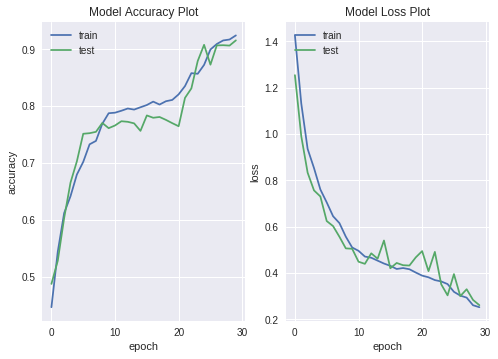

2947/2947 [==============================] - 2s 646us/step


In [23]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_5 = score[0]
model_accuracy_5 = score[1]

In [24]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.2612545601277785, 0.9155072955548015]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  4      404        83        0                   0   
STANDING                 0       85       446        0                   0   
WALKING                  0        0         3      457                  10   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        0         0        1                  36   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           1  
WALKING                           26  
WALKING_DOWNSTAIRS                 0  


####2 Layer Model(Dropout 0.4)

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = 128
dropout_rate = 0.4

In [26]:
# Initiliazing the sequential model
model = Sequential()

#https://adventuresinmachinelearning.com/keras-lstm-tutorial/
#Multilayer LSTM 

model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(LSTM(16,input_shape=(timesteps, 32)))
model.add(Dropout(dropout_rate))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 8,614
Trainable params: 8,614
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.4443 - acc: 0.4720 - val_loss: 1.2855 - val_acc: 0.5056
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.1465 - acc: 0.5824 - val_loss: 1.3007 - val_acc: 0.4700
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9195 - acc: 0.6945 - val_loss: 0.8453 - val_acc: 0.7082
Epoch 4/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.7404 - acc: 0.7692 - val_loss: 0.6909 - val_acc: 0.7822
Epoch 5/30
7352/7352 [==============================] - 32s 4ms/step - loss: 0.6172 - acc: 0.8051 - val_loss: 0.5915 - val_acc: 0.8273
Epoch 6/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.5431 - acc: 0.8247 - val_loss: 0.5569 - val_acc: 0.8202
Epoch 7/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.4689 - acc: 0.8557 - val_loss: 0.4609 - val_acc: 0.8412
Epoch 8

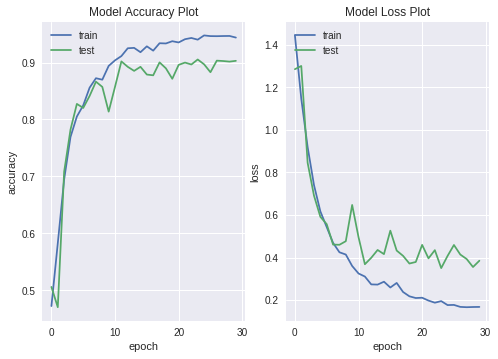

2947/2947 [==============================] - 2s 661us/step


In [28]:
# to plot accuracy/loss plots
accuracy_loss(history)

# score calculation
score = model.evaluate(X_test, Y_test)
model_loss_4 = score[0]
model_accuracy_4 = score[1]

In [29]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.38503823976051715, 0.9029521547336274]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      401        66        0                   0   
STANDING                 0       80       452        0                   0   
WALKING                  0        0         1      448                  18   
WALKING_DOWNSTAIRS       0        0         0        0                 413   
WALKING_UPSTAIRS         0        0         0       17                  17   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           24  
STANDING                           0  
WALKING                           29  
WALKING_DOWNSTAIRS                 7  

####LSTM Single Layer

In [0]:
#defining function

def _model(drop_out,units):
  """
    This function takes drop_out rate and number of units as i/p and return model object for single layer.
  """
  # Initiliazing the sequential model
  model = Sequential()
  model.add(LSTM(units,input_shape=(timesteps, input_dim)))
  model.add(Dropout(drop_out))
  model.add(Dense(n_classes, activation='sigmoid'))
  return model

#####LSTM(128) Dropout = 0.5

In [53]:

model = _model(0.5,128)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 39s 5ms/step - loss: 1.2651 - acc: 0.4387 - val_loss: 1.2087 - val_acc: 0.5070
Epoch 2/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.0999 - acc: 0.5212 - val_loss: 1.2217 - val_acc: 0.4449
Epoch 3/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.9297 

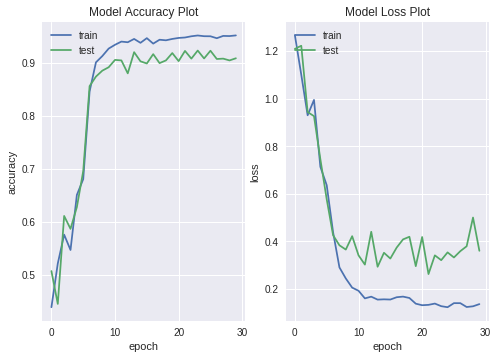

2947/2947 [==============================] - 3s 942us/step


In [54]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer128_5 = score[0]
model_accurac_layer128_5 = score[1]

In [55]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.36085634430697744, 0.9090600610790635]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  1      371       119        0                   0   
STANDING                 0       75       457        0                   0   
WALKING                  0        0         0      470                  23   
WALKING_DOWNSTAIRS       0        0         0        2                 385   
WALKING_UPSTAIRS         0        0         0       12                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            3  
WALKING_DOWNSTAIRS                33  

#####LSTM (128) Dropout = 0.6

In [34]:

model = _model(0.6,128)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 38s 5ms/step - loss: 1.3472 - acc: 0.4283 - val_loss: 1.2467 - val_acc: 0.4520
Epoch 2/30
7352/7352 [==============================] - 37s 5ms/step - loss: 1.1710 - acc: 0.4908 - val_loss: 1.1298 - val_acc: 0.5124
Epoch 3/30
7352/7352 [==============================] - 36s 5ms/step - loss: 0.9417 

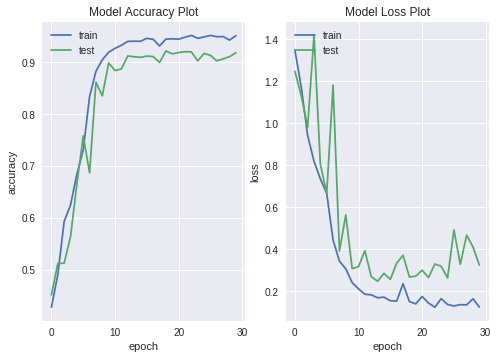

2947/2947 [==============================] - 3s 932us/step


In [35]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer128_6 = score[0]
model_accurac_layer128_6 = score[1]

In [36]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.3239700397747638, 0.9182219205972175]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  1      417        69        1                   0   
STANDING                 0      107       422        1                   0   
WALKING                  0        3         0      465                   4   
WALKING_DOWNSTAIRS       0        3         0        5                 399   
WALKING_UPSTAIRS         0        1         0        4                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           2  
WALKING                           24  
WALKING_DOWNSTAIRS                13  


#####LSTM(128) Dropout = 0.7

In [31]:
model = _model(0.7,128)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 38s 5ms/step - loss: 1.3969 - acc: 0.3904 - val_loss: 1.2773 - val_acc: 0.4272
Epoch 2/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.1794 - acc: 0.4910 - val_loss: 1.1231 - val_acc: 0.5487
Epoch 3/30
7352/7352 [==============================] - 36s 5ms/step - loss: 1.1971 

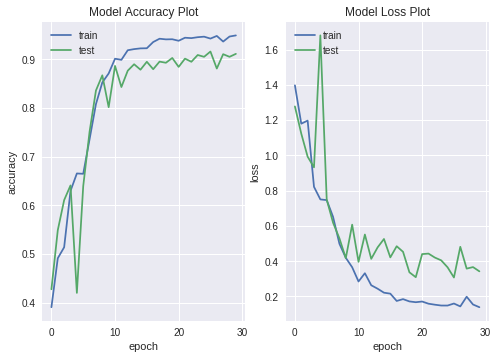

2947/2947 [==============================] - 3s 1ms/step


In [32]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer128_7 = score[0]
model_accurac_layer128_7 = score[1]

In [33]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.3424076799891987, 0.9110960298608755]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         2        0                   0   
SITTING                  0      441        48        0                   0   
STANDING                 0      138       393        1                   0   
WALKING                  0        0         3      471                   1   
WALKING_DOWNSTAIRS       0        0         1        3                 415   
WALKING_UPSTAIRS         0        1         0       15                   0   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            25  
SITTING                            2  
STANDING                           0  
WALKING                           21  
WALKING_DOWNSTAIRS                 1  


#####LSTM(64) Dropout = 0.2

In [50]:
model = _model(0.2,64)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.2610 - acc: 0.4610 - val_loss: 1.3716 - val_acc: 0.3834
Epoch 2/30
7352/7352 [==============================] - 21s 3ms/step - loss: 1.1243 - acc: 0.4984 - val_loss: 1.1482 - val_acc: 0.4601
Epoch 3/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.9148 

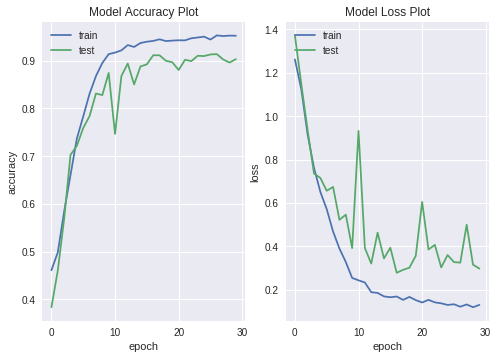

2947/2947 [==============================] - 1s 506us/step


In [51]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer64_2 = score[0]
model_accurac_layer64_2 = score[1]

In [52]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.29805776571111475, 0.9032914828639295]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  7      417        65        0                   1   
STANDING                 0      118       414        0                   0   
WALKING                  0        5         0      456                  13   
WALKING_DOWNSTAIRS       0        2         2        2                 401   
WALKING_UPSTAIRS         0        1         1        8                  24   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           22  
WALKING_DOWNSTAIRS                13  

#####LSTM(64) Dropout = 0.4

In [37]:
model = _model(0.4,64)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 22s 3ms/step - loss: 1.3117 - acc: 0.4399 - val_loss: 1.1738 - val_acc: 0.5005
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.0517 - acc: 0.5541 - val_loss: 0.9539 - val_acc: 0.6132
Epoch 3/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.8158 

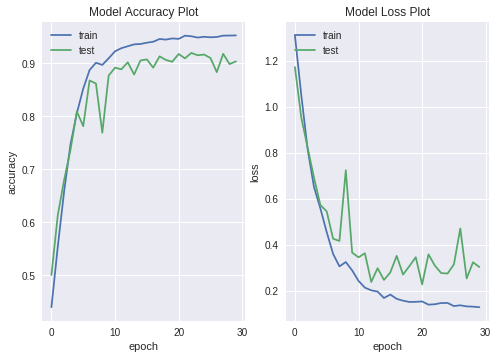

2947/2947 [==============================] - 2s 520us/step


In [38]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer64_4 = score[0]
model_accurac_layer64_4 = score[1]

In [39]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.302408124333561, 0.9032914828639295]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      387       104        0                   0   
STANDING                 0       94       438        0                   0   
WALKING                  0        0         0      467                  21   
WALKING_DOWNSTAIRS       0        0         0        2                 417   
WALKING_UPSTAIRS         0        2         2       23                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            8  
WALKING_DOWNSTAIRS                 1  
W

#####LSTM(64) Dropout = 0.5

In [40]:
model = _model(0.5,64)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.3102 - acc: 0.4328 - val_loss: 1.2069 - val_acc: 0.4506
Epoch 2/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.9980 - acc: 0.5586 - val_loss: 0.9285 - val_acc: 0.5959
Epoch 3/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.8442 

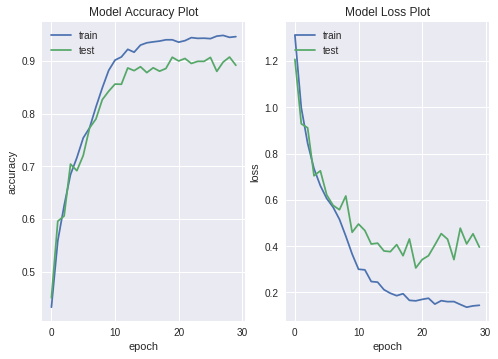

2947/2947 [==============================] - 2s 521us/step


In [41]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer64_5 = score[0]
model_accurac_layer64_5 = score[1]

In [42]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.3958842686579247, 0.8914149983033594]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      426        61        1                   1   
STANDING                 0      150       381        1                   0   
WALKING                  0        0         0      463                  28   
WALKING_DOWNSTAIRS       0        0         0        0                 413   
WALKING_UPSTAIRS         0        0         0       15                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            2  
STANDING                           0  
WALKING                            5  
WALKING_DOWNSTAIRS                 7  


#####LSTM (64) Dropout = 0.6

In [43]:
model = _model(0.6,64)
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

# Training the model
history = model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                18944     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.3415 - acc: 0.4208 - val_loss: 1.2406 - val_acc: 0.4897
Epoch 2/30
7352/7352 [==============================] - 21s 3ms/step - loss: 1.0575 - acc: 0.5528 - val_loss: 0.9778 - val_acc: 0.6451
Epoch 3/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.8356 

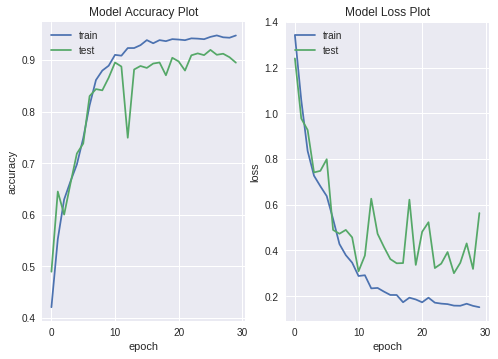

2947/2947 [==============================] - 2s 511us/step


In [44]:
accuracy_loss(history)

score = model.evaluate(X_test, Y_test)
model_loss_layer64_6 = score[0]
model_accurac_layer64_6 = score[1]

In [45]:
# Confusion Matrix
print(score)
print("*"*60)
print(confusion_matrix(Y_test, model.predict(X_test)))

[0.5637321862749768, 0.8948082796063793]
************************************************************
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  0      414        76        1                   0   
STANDING                 0      108       422        2                   0   
WALKING                  0        0         0      478                  18   
WALKING_DOWNSTAIRS       0        0         0        2                 418   
WALKING_UPSTAIRS         0        0         0       57                  19   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            0  
STANDING                           0  
WALKING                            0  
WALKING_DOWNSTAIRS                 0  


####Summary

In [0]:
from prettytable import PrettyTable
summary = PrettyTable()

In [0]:
summary.field_names = ["Model","Dropout","Test Loss","Test Accuracy"]

In [0]:
summary.add_row(["2 Layer LSTM","0.6",model_loss_6,model_accuracy_6])
summary.add_row(["2 Layer LSTM","0.5",model_loss_5,model_accuracy_5])
summary.add_row(["2 Layer LSTM","0.4",model_loss_4,model_accuracy_4])

summary.add_row(["LSTM(128)","0.5",model_loss_layer128_5,model_accurac_layer128_5])
summary.add_row(["LSTM(128)","0.6",model_loss_layer128_6,model_accurac_layer128_6])
summary.add_row(["LSTM(128)","0.7",model_loss_layer128_7,model_accurac_layer128_7])

summary.add_row(["LSTM(64)","0.2",model_loss_layer64_2,model_accurac_layer64_2])
summary.add_row(["LSTM(64)","0.4",model_loss_layer64_4,model_accurac_layer64_4])
summary.add_row(["LSTM(64)","0.5",model_loss_layer64_5,model_accurac_layer64_5])
summary.add_row(["LSTM(64)","0.6",model_loss_layer64_6,model_accurac_layer64_6])

In [59]:
print(summary)

+--------------+---------+---------------------+--------------------+
|    Model     | Dropout |      Test Loss      |   Test Accuracy    |
+--------------+---------+---------------------+--------------------+
| 2 Layer LSTM |   0.6   | 0.28306087015040565 | 0.9104173736002714 |
| 2 Layer LSTM |   0.5   |  0.2612545601277785 | 0.9155072955548015 |
| 2 Layer LSTM |   0.4   | 0.38503823976051715 | 0.9029521547336274 |
|  LSTM(128)   |   0.5   | 0.36085634430697744 | 0.9090600610790635 |
|  LSTM(128)   |   0.6   |  0.3239700397747638 | 0.9182219205972175 |
|  LSTM(128)   |   0.7   |  0.3424076799891987 | 0.9110960298608755 |
|   LSTM(64)   |   0.2   | 0.29805776571111475 | 0.9032914828639295 |
|   LSTM(64)   |   0.4   |  0.302408124333561  | 0.9032914828639295 |
|   LSTM(64)   |   0.5   |  0.3958842686579247 | 0.8914149983033594 |
|   LSTM(64)   |   0.6   |  0.5637321862749768 | 0.8948082796063793 |
+--------------+---------+---------------------+--------------------+


**Conclusion**


1.   Best accuracy of **91.82%** found for configuration of **LSTM(128)** with dropout rate of  0.6
2.   **Overfitting in model** observed with dicrease in dropout as expected



In [0]:
##########Conclusions################
# 1. For 2 layer LSTM maximum accuracy was found to be 91.55 for dropout of 0.5
# 2. Performance has deteriorated for further increase/decrease in dropout rate.

# 3. For Single layer best accuracy found to be 91.82% for dropout rate = 0.6 and number of units 128.
# 4. Model overfitted for dicrease in dropout rate as expected in every case